<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic_csv = 'titanic.csv'
titanic = pd.read_csv(titanic_csv)

titanic.set_index('PassengerId')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
# ANSWER
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#look at null values for 'Age'
titanic[titanic['Age'].isnull()]
#df['Age'].isnull() #this gives you boolean output

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [5]:
#fill in null values for 'Age'
mean_age = titanic['Age'].mean()
titanic['Age'].fillna(mean_age, inplace=True)
#titanic['Age'].isnull().sum() #check

In [6]:
#look at null values for 'Cabin'
titanic[titanic['Cabin'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S


In [7]:
#fill in null values for 'Cabin'
mode_cabin = titanic['Cabin'].mode()
print(mode_cabin)

titanic['Cabin'].value_counts()

0        B96 B98
1    C23 C25 C27
2             G6
dtype: object


B96 B98        4
G6             4
C23 C25 C27    4
F2             3
F33            3
              ..
B78            1
E38            1
E77            1
B3             1
A14            1
Name: Cabin, Length: 147, dtype: int64

In [8]:
#because of nature of Cabin values, better to drop column
titanic = titanic.drop(columns=['Cabin'])
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [9]:
#look at null values of 'Embarked'
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [10]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
embarked_mode = titanic['Embarked'].mode()
titanic['Embarked'].fillna(embarked_mode, inplace=True)

In [12]:
#check
#titanic.iloc[829,:]
#titanic.iloc[61,:]

### 3. Numerical Predictors Only

In [13]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [14]:
# ANSWER
X = titanic[['Pclass', 'Parch']]
y = titanic['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [15]:
# ANSWER
X

,Pclass,Parch
0,3,0
1,1,0
2,3,0
3,1,0
4,3,0
...,...,...
886,2,0
887,1,0
888,3,2
889,1,0


In [16]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [18]:
# ANSWER
# Create Model
lr = LogisticRegression()


Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [19]:
# ANSWER
# Fit Model
lr.fit(X_train, y_train)

LogisticRegression()

In [20]:
lr.score(X_test, y_test)
#output means = model is 67% correct wrt classifying data into survived / did not survive

0.6711864406779661

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [21]:
# ANSWER
lr.coef_

array([[-0.88528877,  0.37910902]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [22]:
# ANSWER
lr.intercept_

array([1.32709322])

We can create tuples of the predictor names and coefficients like this:

In [23]:
# ANSWER
print(set(zip(X_train.columns, lr.coef_[0])))

{('Pclass', -0.8852887719172416), ('Parch', 0.37910902283528286)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [24]:
for col in zip(X_train.columns, lr.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.885289
Parch       +0.379109


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [25]:
# ANSWER
from sklearn.metrics import accuracy_score
y_pred_train = lr.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.6912751677852349

What is the  `accuracy_score` for the test data?

In [26]:
# ANSWER
y_pred_test = lr.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.6711864406779661

What can we say about this result?

ANSWER
- ... 
- ...

In [27]:
#answer
#model is more accurate at correctly classifying data for training set than for test set
#model correctly classifies 67% of data for test set

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [28]:
# ANSWER
X_new = titanic[['Pclass', 'Parch', 'Age']]
y_new = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=1)

In [29]:
# Build Model
lr = LogisticRegression()

# Fit Model
lr.fit(X_train, y_train)

# Score
print(lr.score(X_test, y_test))

0.6745762711864407


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

In [30]:
#answer
#any variance explained by Age is already explained by Pclass/Parch

Let's see where the model is going wrong by showing the Confusion Matrix:

In [31]:
# ANSWER
from sklearn.metrics import confusion_matrix
y_pred_class = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred_class))

[[142  32]
 [ 64  57]]


Nb. Here is how `confusion_matrix` arranges its output:

In [32]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

In [33]:
#answer
#false negatives more prevalent (vs false positives)
#false negatives = actually positive but model classified as negative

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

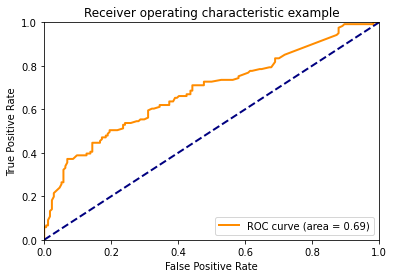

In [34]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
# prediction values: model compares this against threshold and classifies accordingly
y_score = lr.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_score)
    #third output is thresholds

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [35]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [38]:
#stratify (classify) Age by mean (of groups)
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))
#ryan's explanation:
    #we are trying to 1) split passengers into smaller groups (eg male with class 1 ticket)
    #then 2) get average age for that group
    #and 3) filling in average according to profile
#megan's notes:
    #You call .groupby() and pass the name(s) of the column you want to group on
    #Then, you use ["__"] to specify the column(s) on which you want to perform the actual aggregation (transform function)

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [40]:
# ANSWER
# Set Feature Both Numerical, Categorical
X_new1 = titanic_with_dummies[['Age', "Parch", "Sex_male", "Pclass_1", "Pclass_2"]]
y_new1 = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_new1, y_new1, test_size=0.33, random_state=1)

# Build Model
lr = LogisticRegression()

# Fit Model
lr.fit(X_train, y_train)

# Score
print(lr.score(X_test, y_test))

0.7796610169491526


Plot the ROC curve for the new model:

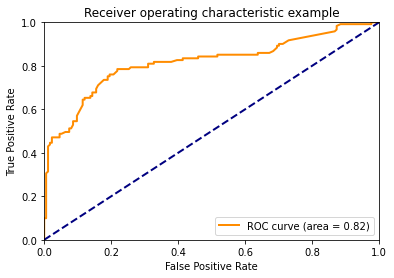

In [41]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
# prediction values: model compares this against threshold and classifies accordingly
y_score = lr.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_score)
    #third output is thresholds

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
#AUC for this model > AUC for previous model 
#this model better

Can we improve the model by including the remaining features?

0.7864406779661017


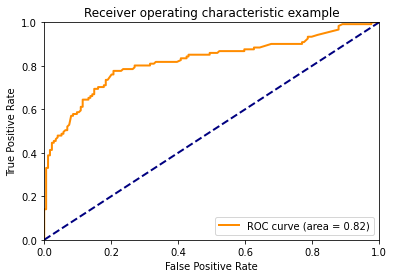

In [42]:
# ANSWER
# Set Feature Both Numerical, Categorical
X_new2 = titanic_with_dummies[['Age', "Parch", "Sex_male", "Pclass_1", "Pclass_2", "Embarked_C", "Embarked_Q"]]
y_new2 = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_new2, y_new2, test_size=0.33, random_state=1)

# Build Model
lr = LogisticRegression()

# Fit Model
lr.fit(X_train, y_train)

# Score
print(lr.score(X_test, y_test))

# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
# prediction values: model compares this against threshold and classifies accordingly
y_score = lr.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_score)
    #third output is thresholds

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
#logreg score doesnt increase significantly and AUC doesn't increase
#adding add. "embarked" variable doesn't improve model considerably

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [ ]:
#1. results should change
#2. use kfold cross validation (refer lab 4.2.1)
#3. 



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



